# Глубинное обучение для текстовых данных, ФКН ВШЭ

## Домашнее задание 2: Рекуррентные нейронные сети

### Оценивание и штрафы

Максимально допустимая оценка за работу — __10 (+5) баллов__. Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Весь код должен быть написан самостоятельно. Чужим кодом для пользоваться запрещается даже с указанием ссылки на источник. В разумных рамках, конечно. Взять пару очевидных строчек кода для реализации какого-то небольшого функционала можно.

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

__Мягкий дедлайн: 14.10.24 23:59__   
__Жесткий дедлайн: 17.10.24 23:59__

### О задании

В этом задании вам предстоит самостоятельно реализовать модель LSTM для решения задачи классификации с пересекающимися классами (multi-label classification). Это вид классификации, в которой каждый объект может относиться одновременно к нескольким классам. Такая задача часто возникает при классификации фильмов по жанрам, научных или новостных статей по темам, музыкальных композиций по инструментам и так далее.

В нашем случае мы будем работать с датасетом биотехнических новостей и классифицировать их по темам. Этот датасет уже предобработан: текст приведен к нижнему регистру, удалена пунктуация, все слова разделены проблелом.

In [20]:
%config InlineBackend.figure_format = "retina"
%matplotlib inline

%load_ext autoreload
%autoreload 2

import torch.nn as nn
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
from collections import defaultdict, Counter
from torch.utils.data import Dataset, DataLoader

import src.tokenizers as tokenizers
import src.utils as utils
import src.models as models
import src.trainers as trainers
from src.utils import TextDataset, collate_fn

STOP_WORDS = set(stopwords.words("english"))
utils.set_random_seed(231)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# FOR DEBUG
nlines = 3040
nsamples = 100
rows = np.random.choice(range(1, nlines), size=nsamples, replace=False)

dataset = pd.read_csv("biotech_news.tsv", sep="\t", skiprows=lambda x: x not in rows and x != 0)
dataset.head()

,text,labels
0,updated 18 03 2021 16 32 ist created 18 03 202...,other
1,notebook lions wide receivers need to step up ...,other
2,mon 21 mar 2022 15 58 alan magee henry de brom...,other
3,update article was updated 1 hr ago a man atte...,other
4,pinterest determination and patience there is ...,other


In [3]:
# dataset = pd.read_csv("biotech_news.tsv", sep="\t")
# dataset.head()

## Предобработка лейблов


__Задание 1 (1.5 балла)__. Как вы можете заметить, лейблы записаны в виде строк, разделенных запятыми. Для работы с ними нам нужно преобразовать их в числа. Так как каждый объект может принадлежать нескольким классам, закодируйте лейблы в виде векторов из 0 и 1, где 1 означает, что объект принадлежит соответствующему классу, а 0 – не принадлежит. Имея такую кодировку, мы сможем обучить модель, решая задачу бинарной классификации для каждого класса.

In [4]:
# inplace меняем наш датасет, тк он оч тяжёлый

binarizer = utils.Binarizer(dataset=dataset, labels_col="labels")
binarizer.transform(dataset, add_every_label=False)

## Предобработка данных

В этом задании мы будем обучать рекуррентные нейронные сети. Как вы знаете, они работают лучше для коротких текстов, так как не очень хорошо улавливают далекие зависимости. Для уменьшение длин текстов их стоит почистить.

Сразу разделим выборку на обучающую и тестовую, чтобы считать все нужные статистики только по обучающей.

In [5]:
texts_train, texts_test, y_train, y_test = train_test_split(
    dataset["text"],
    dataset["binary_labels"],
    test_size=0.2,  # do not change this
    random_state=0  # do not change this
)

__Задание 2 (1.5 балла)__. Удалите из текстов стоп слова, слишком редкие и слишком частые слова. Гиперпараметры подберите самостоятельно (в идеале их стоит подбирать по качеству на тестовой выборке). Если вы считаете, что стоит добавить еще какую-то обработку, то сделайте это. Важно не удалить ничего, что может повлиять на предсказание класса.

In [6]:
word_tokenizer = tokenizers.WordTokenizer(
    min_word_freq=4,
    max_doc_freq=0.5
) #approx 16k words on full dataset

tokenized_train = texts_train.apply(
    lambda x: [word for word in nltk.word_tokenize(x) if word not in STOP_WORDS]
)

tokenized_test = texts_test.apply(
    lambda x: [word for word in nltk.word_tokenize(x) if word not in STOP_WORDS]
)

tokenized_dataset = dataset["text"].apply(
    lambda x: [word for word in nltk.word_tokenize(x) if word not in STOP_WORDS]
)

word_tokenizer.fit(tokenized_train)
dataset["word_indices"] = word_tokenizer.tokens_to_indices(tokenized_dataset)
dataset["word_tokens"] = word_tokenizer.indices_to_tokens(dataset["word_indices"])

__Задание 3 (2 балла)__. Осталось перевести тексты в индексы токенов, чтобы их можно было подавать в модель. У вас есть две опции, как это сделать:
1. __(+0 баллов)__ Токенизировать тексты по словам.
2. __(до +5 баллов)__ Реализовать свою токенизацию BPE. Количество баллов будет варьироваться в зависимости от эффективности реализации. При реализации нельзя пользоваться специализированными библиотеками.

Токенизируйте тексты, переведите их в списки индексов и сложите вместе с лейблами в `DataLoader`. Не забудьте добавить в `DataLoader` `collate_fn`, которая будет дополнять все короткие тексты в батче паддингами. Для маппинга токенов в индексы вам может пригодиться `gensim.corpora.dictionary.Dictionary`.

__1. По словам.__ Дальше будет по BPE

In [21]:
train = word_tokenizer.tokens_to_indices(tokenized_train)
test = word_tokenizer.tokens_to_indices(tokenized_test)

# трейн
train_dataset = TextDataset(train, y_train.values.tolist())
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=lambda batch: collate_fn(batch, max_seq_len=560))

# тест
test_dataset = TextDataset(test, y_test.values.tolist())
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=lambda batch: collate_fn(batch, max_seq_len=560))

__2. BPE__

In [22]:
bpe_tokenizer = tokenizers.BPE(
    vocab_size=20000
)

bpe_tokenizer.fit(tokenized_train) #уже учли ограничения на частоту встречаемости
dataset["bpe_tokens"] = dataset["text"].apply(lambda x: bpe_tokenizer.tokenize(x))
dataset["bpe_indices"] = dataset["bpe_tokens"].apply(lambda x: bpe_tokenizer.tokens_to_indices(x))

KeyboardInterrupt: 

In [14]:
x = bpe_tokenizer.tokenize(dataset["word_tokens"][0])
len(x)

1857

## Метрика качества

Перед тем, как приступить к обучению, нам нужно выбрать метрику оценки качества. Так как в задаче классификации с пересекающимися классами классы часто несбалансированы, чаще всего в качестве метрики берется [F1 score](https://en.wikipedia.org/wiki/F-score).

Функция `compute_f1` принимает истинные метки и предсказанные и считает среднее значение F1 по всем классам. Используйте ее для оценки качества моделей.

$$
F1_{total} = \frac{1}{K} \sum_{k=1}^K F1(Y_k, \hat{Y}_k),
$$
где $Y_k$ – истинные значения для класса k, а $\hat{Y}_k$ – предсказания.

In [11]:
from sklearn.metrics import f1_score

def compute_f1(y_true, y_pred):
    assert y_true.ndim == 2
    assert y_true.shape == y_pred.shape

    return f1_score(y_true, y_pred, average='macro')

## Обучение моделей

### RNN

В качестве бейзлайна обучим самую простую рекуррентную нейронную сеть. Напомним, что блок RNN выглядит таким образом.

<img src="https://i.postimg.cc/yYbNBm6G/tg-image-1635618906.png" alt="drawing" width="400"/>

Его скрытое состояние обновляется по формуле
$h_t = \sigma(W x_{t} + U h_{t-1} + b_h)$. А предсказание считается с помощью применения линейного слоя к последнему токену
$o_T = V h_T + b_o$. В качестве функции активации выберите гиперболический тангенс. 

__Задание 4 (2 балла)__. Реализуйте RNN в соответствии с формулой выше и обучите ее на нашу задачу. Нулевой скрытый вектор инициализируйте нулями, так модель будет обучаться стабильнее, чем при случайной инициализации. После этого замеряйте качество на тестовой выборке. У вас должно получиться значение F1 не меньше 0.33, а само обучение не должно занимать много времени.

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else
                      "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


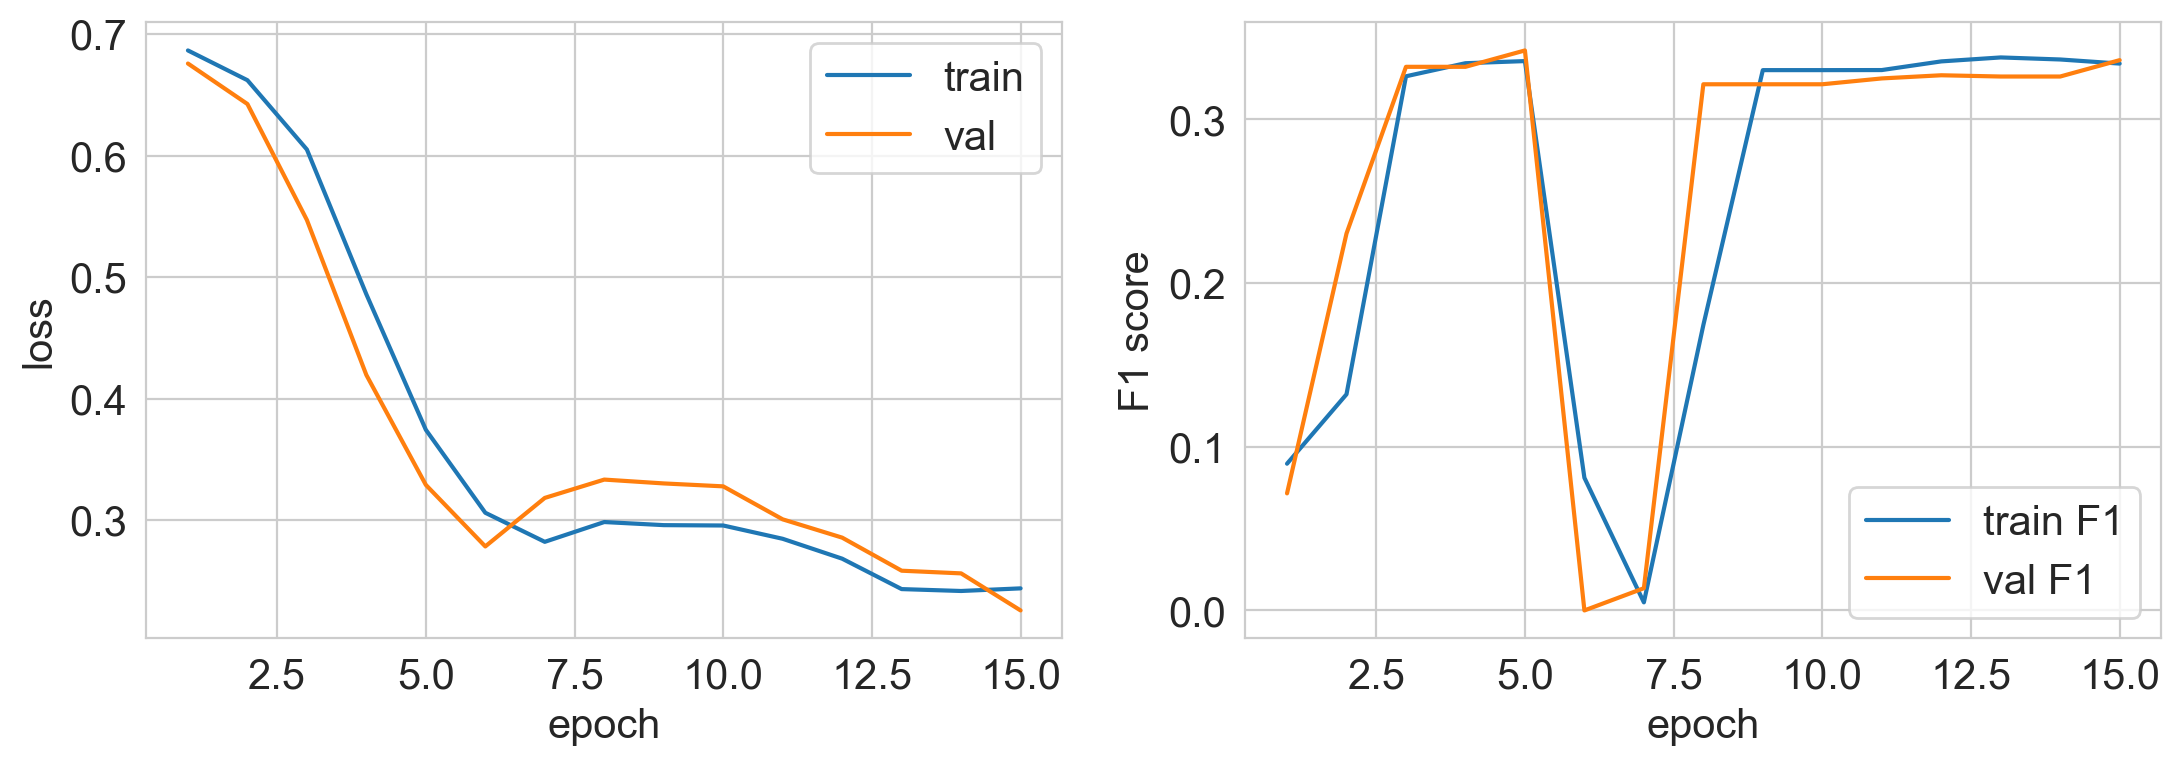

Epoch 15/15, Train Loss: 0.2437, Val Loss: 0.2256
Train F1: 0.3340, Val F1: 0.3361


In [80]:
VOCAB_SIZE = len(word_tokenizer.idx2word)
OUTPUT_SIZE = len(y_train.iloc[0])
EMBEDDING_DIM = 128
HIDDEN_SIZE = 64
NUM_EPOCHS = 15
LR = 3e-4

baseline = models.Baseline(
    vocab_size=VOCAB_SIZE,
    embedding_dim=EMBEDDING_DIM,
    hidden_size=HIDDEN_SIZE,
    output_size=OUTPUT_SIZE
    ).to(device)

optimizer = torch.optim.AdamW(baseline.parameters(), lr=LR, weight_decay=1e-6)
criterion = nn.BCEWithLogitsLoss()

trainer = trainers.Trainer(
    model=baseline,
    optimizer=optimizer,
    scheduler=None,
    train_loader=train_loader,
    val_loader=test_loader,
    num_epochs=NUM_EPOCHS,
    device=device,
    criterion=criterion
)

trainer.train()

Оп, качество получилось лучше чем 0.33, отлично :)

### LSTM

<img src="https://i.postimg.cc/pL5LdmpL/tg-image-2290675322.png" alt="drawing" width="400"/>

Теперь перейдем к более продвинутым рекурренным моделям, а именно LSTM. Из-за дополнительного вектора памяти эта модель должна гораздо лучше улавливать далекие зависимости, что должно напрямую отражаться на качестве.

Параметры блока LSTM обновляются вот так ($\sigma$ означает сигмоиду):
\begin{align}
f_{t} &= \sigma(W_f x_{t} + U_f h_{t-1} + b_f) \\ 
i_{t} &= \sigma(W_i x_{t} + U_i h_{t-1} + b_i) \\
\tilde{c}_{t} &= \tanh(W_c x_{t} + U_c h_{t-1} + b_i) \\
c_{t} &= f_t \odot c_{t-1} + i_t \odot \tilde{c}_t \\
o_{t} &= \sigma(W_t x_{t} + U_t h_{t-1} + b_t) \\
h_t &= o_t \odot \tanh(c_t)
\end{align}

__Задание 5 (2 балла).__ Реализуйте LSTM по описанной схеме. Выберите гиперпараметры LSTM так, чтобы их общее число (без учета слоя эмбеддингов) примерно совпадало с числом параметров обычной RNN, но размерность скрытого слоя была не меньше 64. Так мы будем сравнивать архитектуры максимально независимо. Обучите LSTM до сходимости и сравните качество с RNN на тестовой выборке. Удалось ли получить лучший результат? Как вы можете это объяснить?

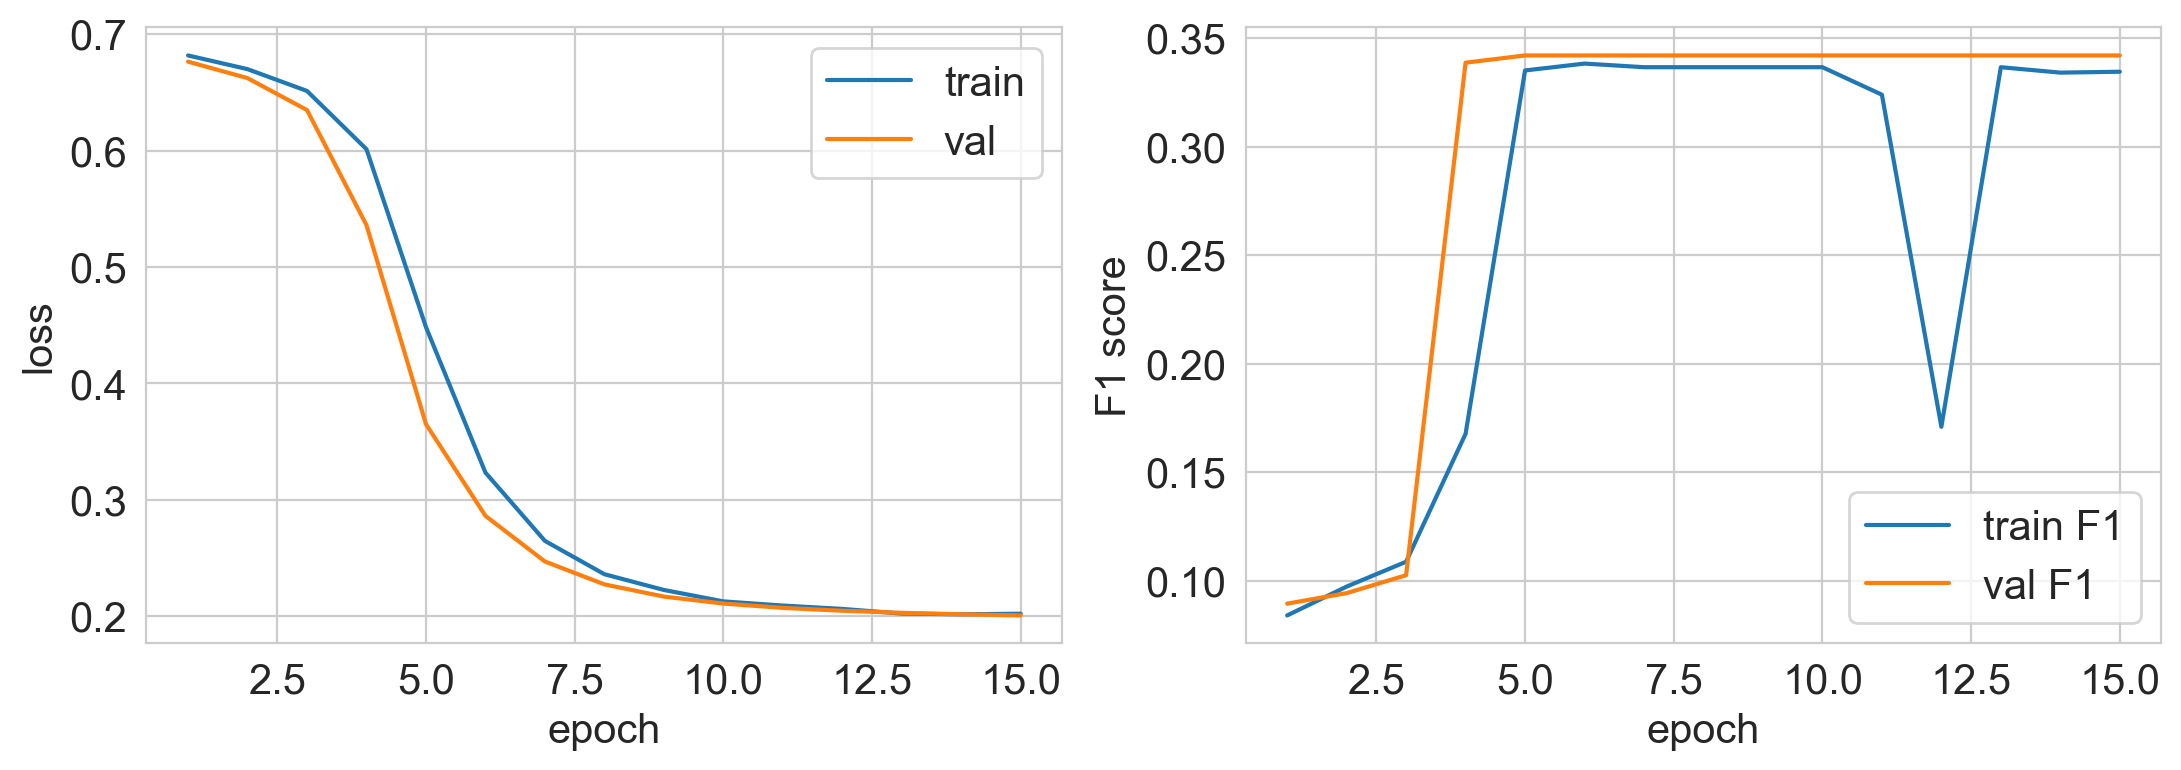

Epoch 15/15, Train Loss: 0.2020, Val Loss: 0.2005
Train F1: 0.3345, Val F1: 0.3420


In [15]:
VOCAB_SIZE = len(word_tokenizer.idx2word)
OUTPUT_SIZE = len(y_train.iloc[0])
EMBEDDING_DIM = 128
HIDDEN_SIZE = 64
NUM_EPOCHS = 15
LR = 3e-4

lstm = models.LSTM(
    vocab_size=VOCAB_SIZE,
    embedding_dim=EMBEDDING_DIM,
    hidden_size=HIDDEN_SIZE,
    output_size=OUTPUT_SIZE
    ).to(device)

optimizer = torch.optim.Adam(lstm.parameters(), lr=LR)
criterion = nn.BCEWithLogitsLoss()

trainer = trainers.Trainer(
    model=lstm,
    optimizer=optimizer,
    scheduler=None,
    train_loader=train_loader,
    val_loader=test_loader,
    num_epochs=NUM_EPOCHS,
    device=device,
    criterion=criterion
)

trainer.train()

И тут качество выше 0.33, но прирост относительно примерно такой же по размеру RNN-ки невелик!

__Задание 6 (1 балл).__ В этом задании у вас есть две опции на выбор: добавить __двунаправленность__ для LSTM _или_ добавить __многослойность__. Можно сделать и то, и другое, но дополнительных баллов за это мы не дадим, только бесконечный респект. Обе модификации реализуются довольно просто (буквально 4 строчки кода, если вы аккуратно реализовали модель) и дают примерно одинаковый прирост в качестве. Сделайте выводы: стоит ли увеличивать размер модели в несколько раз?